<a href="https://colab.research.google.com/github/vent0906/ww/blob/main/self_learn_node_embedding_edge_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial implements node embedding using edge classification on the Karate Club graph.

## Code Directory

1. **Load Karate Club Graph and Visualize**  
2. **Initialize Embeddings for Each Node**  
3. **Visualize Initial Embeddings (PCA 2D Projection)**  
4. **Create Positive and Negative Edges for Supervised Learning**  
5. **Train Node Embeddings via Edge Classification**  
6. **Train and Visualize the Learned Embeddings**


## 1. Load Karate Club Graph and Visualize

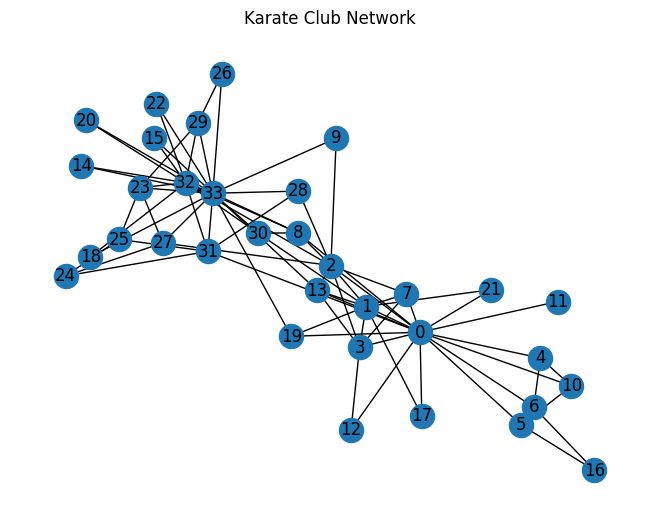

In [ ]:

import networkx as nx
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the Karate Club network graph
graph = nx.karate_club_graph()

# Draw the graph with labels to visualize connections
nx.draw(graph, with_labels=True)
plt.title("Karate Club Network")
plt.show()



### Explanation:
We use NetworkX to load and visualize the Karate Club network which consists of 34 nodes representing club members and edges representing their interactions.


## 2. Initialize Embeddings for Each Node

In [ ]:

torch.manual_seed(1)

# Initialize an embedding table for nodes (34 nodes × 16 dimensions)
def init_node_embeddings(num_nodes=34, dim=16):
    embedding = nn.Embedding(num_nodes, dim)
    embedding.weight.data = torch.rand(num_nodes, dim)
    return embedding

# Create embeddings
node_embeddings = init_node_embeddings()



### Explanation:
We assign each node a 16-dimensional embedding initialized from a uniform distribution using `torch.rand`.


## 3. Visualize Initial Embeddings (PCA 2D Projection)

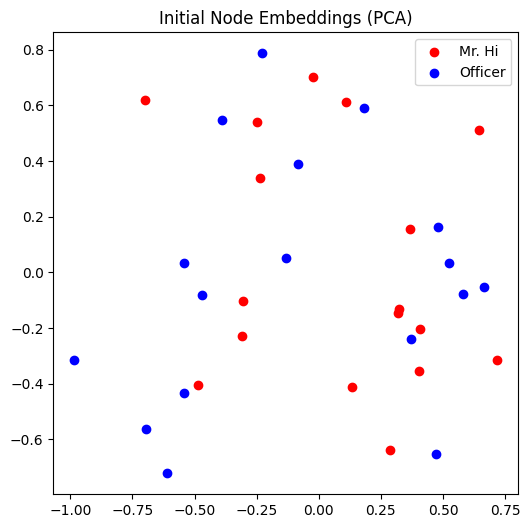

In [ ]:

def visualize_embeddings(embedding):
    # Convert embeddings to numpy for PCA
    features = embedding.weight.data.numpy()
    pca = PCA(n_components=2)
    components = pca.fit_transform(features)

    # Separate members by club label for color coding
    x_hi, y_hi = [], []
    x_off, y_off = [], []

    for node in graph.nodes(data=True):
        idx = node[0]
        club = node[1]['club']
        if club == 'Mr. Hi':
            x_hi.append(components[idx][0])
            y_hi.append(components[idx][1])
        else:
            x_off.append(components[idx][0])
            y_off.append(components[idx][1])

    # Scatter plot with colors for each club
    plt.figure(figsize=(6, 6))
    plt.scatter(x_hi, y_hi, c='red', label='Mr. Hi')
    plt.scatter(x_off, y_off, c='blue', label='Officer')
    plt.legend()
    plt.title("Initial Node Embeddings (PCA)")
    plt.show()

# Visualize
visualize_embeddings(node_embeddings)



### Explanation:
We project the 16-dimensional embeddings to 2D using PCA and visualize them based on club affiliation to observe initial separation.


## 4. Create Positive and Negative Edges for Supervised Learning

In [ ]:

import random

# Convert NetworkX graph to edge list
def graph_to_edge_list(g):
    return list(g.edges())

# Convert edge list to torch tensor
def edge_list_to_tensor(edge_list):
    return torch.LongTensor(edge_list).t()

# Get positive edges from the graph
positive_edges = graph_to_edge_list(graph)
pos_edge_tensor = edge_list_to_tensor(positive_edges)

# Sample equal number of negative edges
def sample_negative_edges(g, num_samples):
    non_edges = list(enumerate(nx.non_edges(g)))
    sampled = random.sample(range(len(non_edges)), num_samples)
    return [non_edges[i][1] for i in sampled]

negative_edges = sample_negative_edges(graph, len(positive_edges))
neg_edge_tensor = edge_list_to_tensor(negative_edges)

print("Positive edge tensor shape:", pos_edge_tensor.shape)
print("Negative edge tensor shape:", neg_edge_tensor.shape)


Positive edge tensor shape: torch.Size([2, 78])
Negative edge tensor shape: torch.Size([2, 78])



### Explanation:
We construct the training data by defining positive edges (real links in the graph) and sampling an equal number of negative edges (non-existent connections).


## 5. Train Node Embeddings via Edge Classification

In [ ]:

from torch.optim import SGD

# Accuracy function to evaluate sigmoid predictions
def compute_accuracy(pred, label):
    correct = (pred > 0.5) == label
    return round(correct.sum().item() / pred.size(0), 4)

# Training function
def train_embeddings(embedding, loss_fn, activation_fn, labels, edges):
    optimizer = SGD(embedding.parameters(), lr=0.1, momentum=0.9)
    for epoch in range(500):
        optimizer.zero_grad()
        node_pair_emb = embedding(edges)  # Shape: [2, num_edges, dim]
        dot_product = torch.sum(node_pair_emb[0] * node_pair_emb[1], dim=1)  # [num_edges]
        predictions = activation_fn(dot_product)
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            acc = compute_accuracy(predictions, labels)
            print(f"Epoch {epoch:03d}: Loss={loss.item():.4f}, Accuracy={acc}")



### Explanation:
We optimize embeddings so that the dot product of node pairs from positive edges approaches 1 and from negative edges approaches 0 using binary cross-entropy loss.


## 6. Train and Visualize the Learned Embeddings

Epoch 000: Loss=1.9806, Accuracy=0.5
Epoch 010: Loss=1.5093, Accuracy=0.5
Epoch 020: Loss=0.9478, Accuracy=0.5
Epoch 030: Loss=0.6733, Accuracy=0.5833
Epoch 040: Loss=0.5634, Accuracy=0.7115
Epoch 050: Loss=0.5067, Accuracy=0.7885
Epoch 060: Loss=0.4637, Accuracy=0.8269
Epoch 070: Loss=0.4240, Accuracy=0.9038
Epoch 080: Loss=0.3854, Accuracy=0.9423
Epoch 090: Loss=0.3478, Accuracy=0.9487
Epoch 100: Loss=0.3118, Accuracy=0.9615
Epoch 110: Loss=0.2783, Accuracy=0.9679
Epoch 120: Loss=0.2477, Accuracy=0.9744
Epoch 130: Loss=0.2203, Accuracy=0.9744
Epoch 140: Loss=0.1961, Accuracy=0.9872
Epoch 150: Loss=0.1748, Accuracy=0.9936
Epoch 160: Loss=0.1563, Accuracy=0.9936
Epoch 170: Loss=0.1402, Accuracy=0.9936
Epoch 180: Loss=0.1263, Accuracy=1.0
Epoch 190: Loss=0.1141, Accuracy=1.0
Epoch 200: Loss=0.1035, Accuracy=1.0
Epoch 210: Loss=0.0943, Accuracy=1.0
Epoch 220: Loss=0.0862, Accuracy=1.0
Epoch 230: Loss=0.0791, Accuracy=1.0
Epoch 240: Loss=0.0728, Accuracy=1.0
Epoch 250: Loss=0.0672, Accura

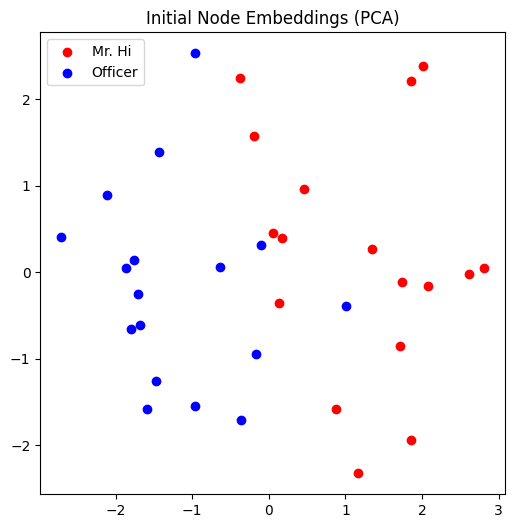

In [ ]:

# Labels for training
labels_pos = torch.ones(pos_edge_tensor.shape[1])
labels_neg = torch.zeros(neg_edge_tensor.shape[1])
all_labels = torch.cat([labels_pos, labels_neg], dim=0)

# Combine edge indices
train_edges = torch.cat([pos_edge_tensor, neg_edge_tensor], dim=1)

# Train
loss_function = nn.BCELoss()
sigmoid = nn.Sigmoid()
train_embeddings(node_embeddings, loss_function, sigmoid, all_labels, train_edges)

# Visualize embeddings after training
visualize_embeddings(node_embeddings)



### Explanation:
We combine all labeled edges and begin training using our dot-product + sigmoid-based classifier. After training, we visualize the updated embeddings again to check separation.
